# Imports

In [1]:
!pip install pysqlite3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysqlite3: filename=pysqlite3-0.5.2-cp310-cp310-linux_x86_64.whl size=47682 sha256=f66b0daa4cf45ead3496849311758ca3fb074a05125d8d9102b8d519ead8e03c
  Stored in directory: /root/.cache/pip/wheels/91/91/77/1912a316aad35d0edcb42ee1aa9b7bc07d7190a5798d378805
Successfully built pysqlite3


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sqlite3
import os

import torch
from torch.utils.data import Dataset, DataLoader

from nltk.tokenize import word_tokenize


from transformers import BertModel, BertTokenizer, BertConfig

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer, BertConfig
from torch.nn import TransformerDecoder, TransformerDecoderLayer


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Reading the data

In [3]:
data=pd.read_json("/kaggle/input/yale-universitys-spider-10-nlp-dataset/spider/train_spider.json")

In [4]:
dbs=data.db_id.unique()

In [5]:
# Define the path to the folder containing subfolders with database files
database_folder = '/kaggle/input/yale-universitys-spider-10-nlp-dataset/spider/database/'

# Initialize lists to store table names and column names
table_names = []
col_names = []
database_dict_db2table={}
database_dict_db2table2cols={}

# Iterate through all subfolders in the database folder
for subfolder in sorted(os.listdir(database_folder)):
    if subfolder in dbs:
        subfolder_path = os.path.join(database_folder, subfolder)
        
        # Check if the subfolder is actually a directory
        if os.path.isdir(subfolder_path):
            # Iterate through all database files in the subfolder
            database_dict_db2table2cols[subfolder]={} #initilize the table2col dict inside the database dict
            for database_file in os.listdir(subfolder_path):
                if database_file.endswith('.sqlite'):
                    # Construct the full path to the database file
                    database_path = os.path.join(subfolder_path, database_file)

                    # Connect to the database
                    conn = sqlite3.connect(database_path)
                    cursor = conn.cursor()

                    # Get the table names
                    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
                    tables = cursor.fetchall()
                    print(f'database name :"{database_file}')
                    
                    temp_tables=[]
                    
                    for table_name in tables:
                        table_names.append(table_name[0].lower())
                        table_name = table_name[0].lower()
#                         print(f'table name :{table_name}')
                        temp_tables.append(table_name)

                        # Get the column names for each table
                        cursor.execute(f"PRAGMA table_info({table_name})")
                        columns = cursor.fetchall()

                        #hena
                        temp_col = []
                        for column in columns:
#                             print(f'col name :{column[1]}')
                            temp_col.append(column[1].lower())
                            col_names.append(column[1].lower())
                        
                
                        #if a table exist in the db to table to col dict then add it to the table dict inside the database dict , else create
                        #a new dict and add it to it
                        database_dict_db2table2cols[subfolder][table_name]=temp_col
                            

                    
                        
        
                    database_dict_db2table[subfolder] = temp_tables #mapping db_id to list of tables inside it

                    # Close the database connection
                    conn.close()

database name :"activity_1.sqlite
database name :"aircraft.sqlite
database name :"allergy_1.sqlite
database name :"apartment_rentals.sqlite
database name :"architecture.sqlite
database name :"assets_maintenance.sqlite
database name :"baseball_1.sqlite
database name :"behavior_monitoring.sqlite
database name :"bike_1.sqlite
database name :"body_builder.sqlite
database name :"book_2.sqlite
database name :"browser_web.sqlite
database name :"candidate_poll.sqlite
database name :"chinook_1.sqlite
database name :"cinema.sqlite
database name :"city_record.sqlite
database name :"climbing.sqlite
database name :"club_1.sqlite
database name :"coffee_shop.sqlite
database name :"college_1.sqlite
database name :"college_2.sqlite
database name :"college_3.sqlite
database name :"company_1.sqlite
database name :"company_employee.sqlite
database name :"company_office.sqlite
database name :"county_public_safety.sqlite
database name :"cre_Doc_Control_Systems.sqlite
database name :"cre_Doc_Tracking_DB.sqli

In [6]:
print(f'example of database to table map of activity_1 database : {database_dict_db2table["activity_1"]} ')

example of database to table map of activity_1 database : ['activity', 'participates_in', 'faculty_participates_in', 'student', 'faculty'] 


In [7]:
print(f'example of database to cols map of activity_1 database : {database_dict_db2table2cols["activity_1"]} ')

example of database to cols map of activity_1 database : {'activity': ['actid', 'activity_name'], 'participates_in': ['stuid', 'actid'], 'faculty_participates_in': ['facid', 'actid'], 'student': ['stuid', 'lname', 'fname', 'age', 'sex', 'major', 'advisor', 'city_code'], 'faculty': ['facid', 'lname', 'fname', 'rank', 'sex', 'phone', 'room', 'building']} 


In [8]:
from nltk import word_tokenize

def process_query(query,max_length=20):
    CLAUSE_KEYWORDS = ('select', 'from', 'where', 'group', 'order', 'limit', 'intersect', 'union', 'except', 'having')
    WHERE_OPS = ('not', 'between', '=', '>', '<', '>=', '<=', '!=', 'in', 'like', 'is', 'exists')
    AGG_OPS = ('max', 'min', 'count', 'sum', 'avg')
    COND_OPS = ('and', 'or')
    ORDER_OPS = ('desc', 'asc')
    query=query.replace(";", "")
    
    def format_clause(tokens):
        tokens.append('END')
        agg = []
        distinct = []
        column1 = []
        op = []
        value = []
        logical_operator = []
        sorting_order = []
        idx = 0
        agg_flag = 0
#         print(tokens)
        if tokens[idx] == 'select':
            # print('here select')
            # print(tokens)
            idx += 1
            while True:
                if tokens[idx] in AGG_OPS:
                    agg.append(tokens[idx])
                    idx += 2
                    agg_flag = 1
                else:
                    agg.append('none')
                if tokens[idx] == 'distinct':
                    distinct.append('DISTINCT')
                    idx += 1
                else:
                    distinct.append('none')
                column1.append(tokens[idx])
                idx += 1
                if agg_flag:
                    idx += 1
                    agg_flag = 0
                op.append('none')
                value.append('none')
                logical_operator.append('none')
                sorting_order.append('none')
                if tokens[idx] != ',':
                    break
                idx += 1

        elif tokens[idx] == 'where':
#             print("here where")
#             print(tokens)
            agg.append('none')
            distinct.append('none')
            idx += 1
            column1.append(tokens[idx])
            idx += 1
#             print(tokens[idx])
            if tokens[idx] in ['!','=', '>', '<', 'like', 'is', 'exists']:
                if tokens[idx+1] == '=':
                    op.append(tokens[idx]+tokens[idx+1])
                    idx+=1
                else:
                    op.append(tokens[idx])

                if tokens[idx + 1] not in ['=', '>', '<', '>=', '<=', '!=', 'like', 'is', 'exists']:
                    value.append(tokens[idx + 1])
                idx += 2
                # logical_operator.append(tokens[idx + 1])
            elif tokens[idx] in ['not', 'in']:
                    if tokens[idx] == 'not':
                        op.append(tokens[idx] + ' ' + tokens[idx + 1])
                        idx += 3
                    else:
                        op.append(tokens[idx])
                        idx += 2
                    if 'select' in tokens:
                        value.append('nested')
                    else:
                        values = ''
                        while True:
                            values += tokens[idx] + ' '
                            idx += 1
                            if tokens[idx] != ',':
                                break
                            idx += 1
                        value.append(values)
            elif tokens[idx] == 'between':
                op.append(tokens[idx])
                idx += 1
                values = ''
                while True:
                    if tokens[idx] not in COND_OPS:
                        values += (tokens[idx] + ' ')
                        idx += 1
                    logical_operator.append(tokens[idx])
                    values += (tokens[idx + 1] + ' ')
                    idx += 2
                    if tokens[idx] == 'END':
                        break
                value.append(values)
            # print(agg,distinct,column1,op,value,logical_operator,sorting_order)


        elif tokens[idx] == 'order' and tokens[idx + 1] == 'by':
            idx += 2
            while True:
                sort_flag = 0
                column1.append(tokens[idx])
                idx += 1
                if tokens[idx] in ORDER_OPS:
                    sorting_order.append(tokens[idx])
                    sort_flag = 1
                    idx += 1
                if sort_flag != 1:
                    sorting_order.append('asc')
                distinct.append('none')
                agg.append('none')
                op.append('none')
                value.append('none')
                logical_operator.append('none')
                if tokens[idx] != ',':
                    break
                idx += 1

        elif tokens[idx] == 'group' and tokens[idx + 1] == 'by':
            idx += 2
            while True:
                column1.append(tokens[idx])
                idx += 1
                distinct.append('none')
                agg.append('none')
                op.append('none')
                value.append('none')
                logical_operator.append('none')
                sorting_order.append('none')
                if tokens[idx] != ',':
                    break
                idx += 1

        elif tokens[idx] == 'having':
            while True:
                if tokens[idx] in AGG_OPS:
                    agg.append(tokens[idx])
                    idx += 2
                    agg_flag = 1
                else:
                    agg.append('none')
                if tokens[idx] == 'distinct':
                    distinct.append('DISTINCT')
                    idx += 1
                else:
                    distinct.append('none')
                if tokens[idx] != 'END':
                    column1.append(tokens[idx])
          
                idx += 1
                if agg_flag:
                    idx += 1
                    agg_flag = 0
                if tokens[idx] in WHERE_OPS:
                    op.append(tokens[idx])
                    value.append(tokens[idx + 1])
                    idx += 2
                    logical_operator.append(tokens[idx + 1])
                elif tokens[idx] == 'between':
                    op.append(tokens[idx])
                    idx += 1
                    values = ''
                    while True:
                        if tokens[idx] not in COND_OPS:
                            values += (tokens[idx] + ' ')
                            idx += 1
                        logical_operator.append(tokens[idx])
                        values += (tokens[idx + 1] + ' ')
                        idx += 2
                        if tokens[idx] == 'END':
                            break
                    value.append(values)
                elif tokens[idx] in ['not', 'in']:
                    op.append(tokens[idx])
                    if tokens[idx] == 'not':
                        op.append(tokens[idx] + ' ' + tokens[idx + 1])
                        idx += 3
                    else:
                        idx += 2
                    values = ''
                    while True:
                        values += tokens[idx] + ' '
                        idx += 1
                        if tokens[idx] != ',':
                            break
                        idx += 1
                    value.append(values)
                else:
                    op.append('none')
                    value.append('none')
                    logical_operator.append('none')
                sorting_order.append('none')
                if tokens[idx] != ',':
                    break
                idx += 1
        # elif tokens[idx] == 'from':
        #     # print('here from')
        #     # print(tokens)
        #     if '(select' in clause:
        #         value.append('nested')
        #     elif 'join' in clause: 
        #         idx = tokens.index('on')+1
        #         column1.append(tokens[idx])
        #     # print(agg,distinct,column1,op,value,logical_operator,sorting_order)
        return agg, distinct, column1, op, value, logical_operator, sorting_order


    tokens = word_tokenize(query.lower())
#     tokens = query.lower().split(" ")

    clauses = []
    clause = []
    bracket_flag = 0
    for token in tokens:
        if token == '(':
            bracket_flag = 1
        elif token == ')':
            bracket_flag = 0
        if token in CLAUSE_KEYWORDS:
            if clause:
                if(bracket_flag == 0):
                    clauses.append(clause)
                    clause = []  
        clause.append(token)
    clauses.append(clause)  # Add the last clause
    clauses_keywords = ['select', 'where', 'group', 'order']
    formatted_clauses = []
    i = 0
    
    for clause in clauses:
        # print(clause)
        # print("in loop")
        if clause[0] in clauses_keywords:#, 'from']:
            while clause[0] != clauses_keywords[i%4]:
                i += 1
                formatted_clauses.append("missing clause")
            i += 1
            formatted_clause = format_clause(clause)
            formatted_clauses.append(formatted_clause)
            # print(formatted_clause)
    while i<4:
        i += 1
        formatted_clauses.append("missing clause")

    CAT =[]
    # print(formatted_clauses)
    for formatted_clause in formatted_clauses:
        max_elements = max(len(lst) for lst in formatted_clause)
        result = []
        
        for i in range(max_elements):
            if formatted_clause != "missing clause":    
                sub_list = []
                for lst in formatted_clause:
                    # print(lst)
                    # print("HERE")
                    if i < len(lst):
                        sub_list.append(lst[i])
                    else:
                        sub_list.append('none')
                result.append(sub_list)
            # print(result)
        for sub_list in result:
            CAT.append(sub_list)
        CAT.append(['EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY'])

    
    

    #add <SOS> and <EOS> tokens which is used in the generation 
    sos=['<SOS>']*7
    eos=['<EOS>']*7
    
    CAT.insert(0, sos) #insert the SOS to the start of the sequance
    CAT.append(eos) #inset the EOS to the end of the sequance

    
    padding = [['<PAD>'] * 7] * (max_length - len(CAT)) #padding to max length
    CAT.extend(padding)

    return CAT

In [9]:
data_slice=data[:3400] #took a slice of the dataset to test the model.
sliceData=data_slice['query'].apply(process_query).to_list()

In [10]:
data_slice['query'][0]

'SELECT count(*) FROM head WHERE age  >  56'

In [11]:
sliceData[0]

[['<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>'],
 ['count', 'none', '*', 'none', 'none', 'none', 'none'],
 ['EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY'],
 ['none', 'none', 'age', '>', '56', 'none', 'none'],
 ['EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY'],
 ['EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY'],
 ['EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY'],
 ['<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>'],
 ['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'],
 ['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'],
 ['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'],
 ['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'],
 ['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'],
 ['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'],
 ['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'],
 ['<PAD>', '<PAD>', '<PAD>', '<P

In [12]:
from sklearn.preprocessing import LabelEncoder
def getCATVocab(CATdata,col_names,table_names):
    AGG_special_tokens=['max','min', 'count', 'sum', 'avg']
    OPS_special_tokens=['not', 'between', '=', '>', '<', '>=', '<=', '!=', 'in','not in', 'like', 'is', 'exists']
    COND_special_tokens=['and', 'or']
    ORDERBY_special_tokens=['desc', 'asc']
    DISTINCT_special_tokens=['DISTINCT']
    static_tokens=['<PAD>','none','EMPTY','<SOS>','<EOS>'] #tokens that exist in every slot
    
    all_special_tokens=static_tokens+OPS_special_tokens+COND_special_tokens+ORDERBY_special_tokens+DISTINCT_special_tokens
    
    AGG_vocab=static_tokens+AGG_special_tokens
    OPS_vocab=static_tokens+OPS_special_tokens
    COND_vocab=static_tokens+COND_special_tokens
    ORDER_vocab=static_tokens+ORDERBY_special_tokens
    DISTINCT_vocab=static_tokens+DISTINCT_special_tokens
    
    
    
    value_vocab=[] #empty list to add all values
    col_names_including_aliases_in_query=[]
    for idx,CAT in enumerate(CATdata):
        valueSlotList=[row[4] for row in CAT]
        colSlotList=[row[2] for row in CAT]
        for value in valueSlotList:
            if value in all_special_tokens: #don't add special tokens
                continue
            value_vocab.append(value)
            
        for col in colSlotList:
            if col in all_special_tokens: #don't add special tokens
                continue
            col_names_including_aliases_in_query.append(col)

            
    col_names=list(set(col_names+col_names_including_aliases_in_query+['*']))
    table_names=list(set(table_names))
    values=list(set(value_vocab))

    cols_vocab=static_tokens+col_names
    value_vocab=static_tokens+values
    table_vocab=static_tokens+table_names

    


    
    total_vocab=static_tokens+OPS_special_tokens+COND_special_tokens+ORDERBY_special_tokens+DISTINCT_special_tokens+list(set(AGG_special_tokens+col_names+table_names+values))
    
    
    
    AGG_indices = [i for i, word in enumerate(total_vocab) if word in AGG_vocab]
    OPS_indices = [i for i, word in enumerate(total_vocab) if word in OPS_vocab]
    COND_indices = [i for i, word in enumerate(total_vocab) if word in COND_vocab]
    ORDERBY_indices = [i for i, word in enumerate(total_vocab) if word in ORDER_vocab]
    VALUE_indices = [i for i, word in enumerate(total_vocab) if word in value_vocab]
    DISTINCT_indices = [i for i, word in enumerate(total_vocab) if word in DISTINCT_vocab]
    TABLE_indices = [i for i, word in enumerate(total_vocab) if word in table_vocab]
    COL_indices = [i for i, word in enumerate(total_vocab) if word in cols_vocab]


    
# # # # # # # #
    total_vocab_dict = {token:idx for idx, token in enumerate(total_vocab)}
    
    indices={'agg':AGG_indices
             ,'ops':OPS_indices
             ,'conj':COND_indices
             ,'orderBy':ORDERBY_indices
             ,'distinct':DISTINCT_indices
            ,'col':COL_indices
            ,'value':VALUE_indices
            ,'table':TABLE_indices}
    return total_vocab_dict,indices
            
           
    



In [13]:
total_vocab_dict,indices=getCATVocab(sliceData,col_names,table_names)

In [14]:
reverse_total_vocab= {value: key for key, value in total_vocab_dict.items()}

In [15]:
len(total_vocab_dict)

3167

In [16]:
#this function purpose is to convert CAT lists into numeric representation
def process_CATS(CATS, total_vocab):
    # Create a deep copy of CATS
    temp_CATS = [CAT.copy() for CAT in CATS]

    # Iterate through the CATS and convert tokens to numeric representation
    for CAT in temp_CATS:
        for i in range(len(CAT)):
            token = CAT[i]
            CAT[i] = [total_vocab[x] for x in token]  # Map tokens to their numeric representation
            
    #turn it into a 3d np array with shape (length , max_length,7)
    CAT_numpy=np.zeros((len(temp_CATS),20,7))
    
    for idx in range(len(temp_CATS)):
        CAT_numpy[idx]=np.array(temp_CATS[idx],dtype=np.int32)
        
    return CAT_numpy
    

In [17]:
def CATStoQuery(CATS_numeric,reverse_total_vocab_dict):
    query="SELECT "
    CATS_total=[]
    for CAT in CATS_numeric:
        CAT_mapped=[reverse_total_vocab_dict[slot] for slot in CAT]
        CATS_total.append(CAT_mapped)

    clause=0
    select=0
    whereHaving=0
    groupBy=0
    orderBy=0
    
    for row in CATS_total:
#         print(row)
        if row[0] == '<SOS>':
            continue
        if row[0] == '<EOS>': 
            break
        if row[0] == 'EMPTY':#clause switch
            query+=" "
            clause+=1
            continue
            
        
        if clause==0: #select clause
            if select !=0: #there is a selected element
                query+=","

            if row[0] != 'none': #if there is an AGG function , it should wrap that column name in the same CAT
                query+=row[0]+"("
                query+=row[2]+")"
                select+=1
            else:
                query+=row[2]
                select+=1
            
            
        if clause==1:#whereHaving
            if whereHaving ==0:
                query+='WHERE '
                whereHaving+=1
            if row[2]!='none':
                query+=row[2]+" "
                query+=row[3]+" "
                query+=row[4]
                
        if clause==2: #group by
            if groupBy ==0:
                query+='GROUP BY '
                groupBy+=1
            else:
                query+=','
                
            if row[2]!='none':
                query+=row[2]+" "
                
            
        if clause==3: #group by
            if orderBy ==0:
                query+='ORDER BY '
                orderBy+=1
            else:
                query+=','
            if row[2]!='none':
                query+=row[2]+" "
                query+=row[6]

#     print(query)
        
                
        
    return query

In [18]:
CATS_numeric=process_CATS(sliceData,total_vocab_dict)

In [19]:
class CATDataset(Dataset):
    def __init__(self,CATS,db2table,db2table2cols,db_ids,questions,queries,bert_pretrained_model):
        super().__init__()
        self.db2table_dict=db2table
        self.db2table2cols_dict=db2table2cols
        self.db_ids=db_ids
        self.questions=questions
        self.queries=queries
        self.CATS=CATS
        
        self.tokenizer=bert_tokenizer=BertTokenizer.from_pretrained(bert_pretrained_model)

            
    def __len__(self):
        return len(self.questions)
    
    
    
    def getQuestionSchemaTokens(self,idx):
        tabels=self.db2table_dict[self.db_ids[idx]]        
        question=self.questions[idx]
                
        st=question+' [SEP] '+' '.join(tabels)+' [SEP] '
        for table in tabels:
            cols=self.db2table2cols_dict[self.db_ids[idx]][table]
            st=st+' '.join(cols)
            st=st+' [SEP] '            
        tokenized=self.tokenizer.encode_plus(st,max_length=400,
                                    padding='max_length',
                                    return_tensors='pt')
        return tokenized
        

    def __getitem__(self, idx):
        tokenized_input = self.getQuestionSchemaTokens(idx)
        return tokenized_input,self.CATS[idx],self.queries[idx]


In [20]:
data_slice

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'except': None, 'from': {'conds': [], 'table_..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'except': None, 'from': {'conds': [], 'table_..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'except': None, 'from': {'conds': [], 'table_..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'except': None, 'from': {'conds': [], 'table_..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'except': None, 'from': {'conds': [], 'table_..."
...,...,...,...,...,...,...,...
3395,manufacturer,"SELECT open_year , name FROM manufacturer ORD...","[SELECT, open_year, ,, name, FROM, manufacture...","[select, open_year, ,, name, from, manufacture...",Which manufacturer has the most number of shop...,"[Which, manufacturer, has, the, most, number, ...","{'except': None, 'from': {'conds': [], 'table_..."
3396,manufacturer,SELECT avg(Num_of_Factories) FROM manufacturer...,"[SELECT, avg, (, Num_of_Factories, ), FROM, ma...","[select, avg, (, num_of_factories, ), from, ma...",Find the average number of factories for the m...,"[Find, the, average, number, of, factories, fo...","{'except': None, 'from': {'conds': [], 'table_..."
3397,manufacturer,"SELECT name , manufacturer_id FROM manufactur...","[SELECT, name, ,, manufacturer_id, FROM, manuf...","[select, name, ,, manufacturer_id, from, manuf...",List all manufacturer names and ids ordered by...,"[List, all, manufacturer, names, and, ids, ord...","{'except': None, 'from': {'conds': [], 'table_..."
3398,manufacturer,"SELECT name , open_year FROM manufacturer WHE...","[SELECT, name, ,, open_year, FROM, manufacture...","[select, name, ,, open_year, from, manufacture...",Give me the name and year of opening of the ma...,"[Give, me, the, name, and, year, of, opening, ...","{'except': None, 'from': {'conds': [], 'table_..."


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_testAndVal, y_train, y_testAndVal = train_test_split(data_slice, CATS_numeric, test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testAndVal, y_testAndVal, test_size=0.5, random_state=42)

print(f'number of train data {len(X_train)}')
print(f'number of test data {len(X_test)}')
print(f'number of val data {len(X_val)}')

number of train data 2720
number of test data 340
number of val data 340


In [22]:
train_dataset=CATDataset(y_train,database_dict_db2table,database_dict_db2table2cols,X_train['db_id'].to_list(),X_train['question'].to_list(),X_train['query'].to_list(),'bert-base-uncased')
test_dataset=CATDataset(y_test,database_dict_db2table,database_dict_db2table2cols,X_test['db_id'].to_list(),X_test['question'].to_list(),X_test['query'].to_list(),'bert-base-uncased')
val_dataset=CATDataset(y_val,database_dict_db2table,database_dict_db2table2cols,X_val['db_id'].to_list(),X_val['question'].to_list(),X_val['query'].to_list(),'bert-base-uncased')

In [23]:
train_dataloader=DataLoader(train_dataset, batch_size=16,shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=16,shuffle=False)
val_dataloader=DataLoader(val_dataset, batch_size=16,shuffle=False)

In [24]:
train_dataset.__getitem__(1)

({'input_ids': tensor([[  101,  2054,  2003,  1996,  8909,  1998,  2155,  2171,  1997,  1996,
           4062,  2040,  2038,  1996,  6493,  5001,  7292,  1029,   102, 13782,
           3837,  6853,  3570,  3692,  9570,  5668,  9570,  5668,  5794,  4667,
           2015,  3463,  6853,  5794,  4667,  2015,  9570,  2953,  6072, 11314,
           2015,  6042, 14496, 25181,  5001,  7292,  2015,   102,  4984,  3593,
           4984,  2890,  2546,  2171,  3295,  2406,  2474,  2102,  1048,  3070,
          12456, 24471,  2140,   102,  2679,  3593,  2095,  2461,  4984,  3593,
           2171,  3058,  2051, 24471,  2140,   102,  4062,  3593,  4062,  2890,
           2546,  2193,  3642, 18921, 18442, 11988,  2079,  2497, 10662, 24471,
           2140,   102,  3570,  3593,  3570,   102,  2095, 24471,  2140,   102,
           9570, 10050,  2094,  9570,  2953,  2890,  2546,  2171, 10662, 24471,
           2140,   102,  9570,  5668,  5794,  4667,  5332,  2094,  2679,  3593,
           9570, 10050,  2

In [25]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=20):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)

In [26]:
class CATDecoder(nn.Module):
    def __init__(self,bert_pretrained_model, transformer_config,model_config,DEVICE):
        super(CATDecoder, self).__init__()
        self.device=DEVICE
        self.soft_max=nn.Softmax(dim=2)
        self.dropout=0.1
        self.positional_encoding=PositionalEncoding(d_model=transformer_config['d_model'],dropout=self.dropout,max_len=model_config['tgt_max_length'])
        #indices
        self.col_indices=model_config['col_indices']
        self.value_indices=model_config['value_indices']
        self.table_indices=model_config['table_indices']
        #vocab embeddings
        self.vocab_embedding=nn.Embedding(model_config['vocab_size'],256,padding_idx=0)
        ##
        # BERT Encoder & tokenizer
        self.bert_encoder = BertModel.from_pretrained(bert_pretrained_model)
        
        # Transformer Decoder & Transformers decoder layers
        self.transformer_decoder_layer=TransformerDecoderLayer(
                d_model=transformer_config['d_model'],
                nhead=transformer_config['nhead'],
                dim_feedforward=transformer_config['dim_feedforward'],
                dropout=transformer_config['dropout'],
                activation=transformer_config['activation'],
                layer_norm_eps=transformer_config['layer_norm_eps'],
                batch_first=transformer_config['batch_first'], #(batch, seq, feature), # Not default but i prefer this
                norm_first=transformer_config['norm_first'] , 
            )
    
        self.transformer_decoder = TransformerDecoder(
            decoder_layer=self.transformer_decoder_layer,
            num_layers=transformer_config['num_layers'],
            #norm – the layer normalization component (optional).
        );
        
        ####
        #Bridge layer to map from 768 to 256 (the desired hidden state from bert encoder to cat decoder since their hidden states are not of the same size)
        
        self.linear_projection = nn.Linear(768, transformer_config['d_model'])  # the input size (768) BERT and output size (d_model)
        
        
        #5 simple classifiers for AGG ,DISTINCT , OP , CONJ , ORDERBY
        self.AGG_linear=nn.Linear(256,model_config['AGG_vocab_size'])
        self.DISTINCT_linear=nn.Linear(256,model_config['DISTINCT_vocab_size'])
        self.CONJ_linear=nn.Linear(256,model_config['CONJ_vocab_size'])
        self.OPS_linear=nn.Linear(256,model_config['OPS_vocab_size'])
        self.ORDERBY_linear=nn.Linear(256,model_config['ORDERBY_vocab_size'])

    def get_src_padding_mask(self, inp):
        return (inp == 0)
    
    def get_tgt_padding_mask(self, inp):
        return (inp[:, :, 0] == 0)

    def get_tgt_mask(self,length):
        return torch.nn.Transformer().generate_square_subsequent_mask(length).to(self.device)
    
    def pointer_network(self, embedding_vector, hidden_state):
        """
        embedding_vector of shape (vocab_size, hidden_dim)
        hidden_state of shape (batch_size, seq_length, hidden_dim)
        Transpose hidden_state to (hidden_dim, seq_length, batch_size)
        Reshape hidden_state to (hidden_dim, seq_length * batch_size)
        Compute scores as the matrix product of embedding_vector and reshaped hidden_state
        Reshape scores to (vocab_size, seq_length, batch_size)
        Transpose scores to (batch_size, seq_length, vocab_size)
        """
        batch_size = hidden_state.size(0)
        seq_length = hidden_state.size(1)
        hidden_dim = hidden_state.size(2)

        hidden_state = hidden_state.permute(2, 1, 0)  # Transpose hidden_state
        reshaped_hidden_state = hidden_state.reshape(hidden_dim, -1)  # Reshape hidden_state using reshape

        scores = torch.matmul(embedding_vector, reshaped_hidden_state)  # Compute scores

        scores = scores.reshape(embedding_vector.size(0), seq_length, batch_size)  # Reshape scores using reshape
        return scores.permute(2, 1, 0)  # Transpose scores
    
    def forward(self,tgt,memory):        
        #returns output of all hidden states,pooled output (avg of all of them (ignored))
        src_seq_encoded,_=self.bert_encoder(input_ids=memory.input_ids.squeeze(1),attention_mask=memory.attention_mask.squeeze(1),return_dict=False)

        batch_size = src_seq_encoded.size(0)  
        seq_length = src_seq_encoded.size(1)   
        src_seq_encoded = src_seq_encoded.view(-1, src_seq_encoded.size(-1))    # reshape to (batch_size * seq_length, hidden_state_dims)
        src_seq_encoded = self.linear_projection(src_seq_encoded)  # Output shape: (batch_size * seq_length, 256)
        src_seq_encoded = src_seq_encoded.view(batch_size, seq_length, -1)  # Reshape back to (batch_size, seq_length, output_dims)
        src_padding_mask=self.get_src_padding_mask(memory.input_ids.squeeze(1))
        
        tgt_padding_mask=self.get_tgt_padding_mask(tgt)
        tgt_mask=self.get_tgt_mask(tgt.size(1))
        
        tgt_seq_encoded = self.vocab_embedding(tgt.long()) #output is of shape (batch_size,seq_length,7,256)
        tgt_seq_decoder=torch.mean(tgt_seq_encoded, dim=2) #avg on the 2 dim to get output shape of (batch_size,seq_length,256)
        

        #add posinional encoding to the targets
        tgt_seq_decoder=self.positional_encoding(tgt_seq_decoder)        
        decoder_outputs=self.transformer_decoder(tgt=tgt_seq_decoder,memory=src_seq_encoded
                                                 ,tgt_mask=tgt_mask,tgt_key_padding_mask=tgt_padding_mask
                                                 ,memory_key_padding_mask=src_padding_mask)
        
        col_pointer=self.pointer_network(self.vocab_embedding.weight[self.col_indices],decoder_outputs)
        value_pointer=self.pointer_network(self.vocab_embedding.weight[self.value_indices],decoder_outputs)
        
        
        # 5x Classifiers for AGG,DISTINCT,CONJ,OP,ORDERBY
        AGG_slots_linear=self.AGG_linear(decoder_outputs)
        DISTINCT_slots_linear=self.DISTINCT_linear(decoder_outputs)
        CONJ_slots_linear=self.CONJ_linear(decoder_outputs)
        ORDERBY_slots_linear=self.ORDERBY_linear(decoder_outputs)
        OPS_slots_linear=self.OPS_linear(decoder_outputs)
        #logits
        AGG_slots_logits=self.soft_max(AGG_slots_linear)
        DISTINCT_slots_logits=self.soft_max(DISTINCT_slots_linear)
        CONJ_slots_logits=self.soft_max(CONJ_slots_linear)
        ORDERBY_slots_logits=self.soft_max(ORDERBY_slots_linear)
        OPS_slots_logits=self.soft_max(OPS_slots_linear)
        
        col_pointer_logits=self.soft_max(col_pointer)
        value_pointer_logits=self.soft_max(value_pointer)
        
        CATS_linear={'agg':AGG_slots_linear,'distinct':DISTINCT_slots_linear,'cols':col_pointer,'value':value_pointer,'conj':CONJ_slots_linear,'ops':OPS_slots_linear,'orderBy':ORDERBY_slots_linear}
        CATS_logits={'agg':AGG_slots_logits,'distinct':DISTINCT_slots_logits,'cols':col_pointer_logits,'value':value_pointer_logits,'conj':CONJ_slots_logits,'ops':OPS_slots_logits,'orderBy':ORDERBY_slots_logits}
        return decoder_outputs,CATS_linear,CATS_logits
        

        

In [27]:
import torch.optim as optim
from tqdm import tqdm

# Example configurations
bert_pretrained_model = 'bert-base-uncased'
transformer_config = {
    'd_model': 256,            # BERT's output hidden size
    'nhead': 8,
    'num_layers':4,
    'dim_feedforward':2048, #default
    'dropout':0.1,          #default
    'activation':'relu',    #default
    'layer_norm_eps':1e-5,  #default
    'batch_first':True,      #(batch, seq, feature), # Not default but i prefer this
    'norm_first':False ,    #default
}

model_config = {
    'vocab_size': len(total_vocab_dict),
    'AGG_vocab_size':len(indices['agg']),
    'DISTINCT_vocab_size':len(indices['distinct']),
    'COLS_vocab_size':len(indices['col']),
    'TABLE_vocab_size':len(indices['table']),
    'VALUE_vocab_size':len(indices['value']),
    'OPS_vocab_size':len(indices['ops']),
    'CONJ_vocab_size':len(indices['conj']),
    'ORDERBY_vocab_size':len(indices['orderBy']),
    'col_indices':indices['col'],
    'value_indices':indices['value'],
    'table_indices':indices['table'],
    'tgt_max_length':20
}
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Instantiate the model
model = CATDecoder(bert_pretrained_model, transformer_config,model_config,DEVICE).to(DEVICE)

EPOCHS=100
loss_fn =nn.CrossEntropyLoss().to(DEVICE)
LEARNING_RATE=3e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
def train_epoch(model, data_loader, loss_fn, optimizer,indicies, device):
    model = model.train()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    for tok_inputs,CATS,query in tqdm(data_loader):
        CATS = CATS.to(device)
        tok_inputs = tok_inputs.to(device)

        optimizer.zero_grad()
        
        decoder_outputs,CATS_linear,CATS_logits = model(tgt=CATS[:,:-1,:],memory=tok_inputs)
        
        predictions_linear_AGG = torch.argmax(CATS_logits['agg'],dim=2)
        predictions_linear_AGG = torch.tensor([[indices['agg'][item] for item in row] for row in predictions_linear_AGG.tolist()],device=device)

        predictions_linear_DISTINCT = torch.argmax(CATS_logits['distinct'],dim=2)
        predictions_linear_DISTINCT = torch.tensor([[indices['distinct'][item] for item in row] for row in predictions_linear_DISTINCT.tolist()],device=device)
        
        predictions_linear_OPS=torch.argmax(CATS_logits['ops'],dim=2)
        predictions_linear_OPS=torch.tensor([[indices['ops'][item] for item in row] for row in predictions_linear_OPS.tolist()],device=device)
        
        predictions_linear_CONJ=torch.argmax(CATS_logits['conj'],dim=2)
        predictions_linear_CONJ=torch.tensor([[indices['conj'][item] for item in row] for row in predictions_linear_CONJ.tolist()],device=device)

        predictions_linear_ORDERBY = torch.argmax(CATS_logits['orderBy'],dim=2)
        predictions_linear_ORDERBY=torch.tensor([[indices['orderBy'][item] for item in row] for row in predictions_linear_ORDERBY.tolist()],device=device)

        predictions_pointer_COLS=torch.argmax(CATS_logits['cols'],dim=2)
        predictions_pointer_COLS=torch.tensor([[indices['col'][item] for item in row] for row in predictions_pointer_COLS.tolist()],device=device)

        predictions_pointer_VALUES=torch.argmax(CATS_logits['value'],dim=2)
        predictions_pointer_VALUES=torch.tensor([[indices['value'][item] for item in row] for row in predictions_pointer_VALUES.tolist()],device=device)

        
        
        
        total_predictions+=predictions_linear_AGG.size(0)*predictions_linear_AGG.size(1)
        total_predictions+=predictions_linear_DISTINCT.size(0)*predictions_linear_DISTINCT.size(1)
        total_predictions+=predictions_pointer_COLS.size(0)*predictions_pointer_COLS.size(1)
        total_predictions+=predictions_pointer_VALUES.size(0)*predictions_pointer_VALUES.size(1)
        total_predictions+=predictions_linear_OPS.size(0)*predictions_linear_OPS.size(1)
        total_predictions+=predictions_linear_CONJ.size(0)*predictions_linear_CONJ.size(1)
        total_predictions+=predictions_linear_ORDERBY.size(0)*predictions_linear_ORDERBY.size(1)
        

        correct_predictions += (predictions_linear_AGG == CATS[:,1:,0].long()).sum().item()
        correct_predictions += (predictions_linear_DISTINCT == CATS[:,1:,1].long()).sum().item()
        correct_predictions += (predictions_pointer_COLS == CATS[:,1:,2].long()).sum().item()
        correct_predictions += (predictions_linear_OPS == CATS[:,1:,3].long()).sum().item()
        correct_predictions += (predictions_pointer_VALUES == CATS[:,1:,4].long()).sum().item()
        correct_predictions += (predictions_linear_CONJ == CATS[:,1:,5].long()).sum().item()
        correct_predictions += (predictions_linear_ORDERBY == CATS[:,1:,6].long()).sum().item()

    
        AGG_slot_mapped=torch.tensor([[indices['agg'].index(item) for item in row] for row in CATS[:,1:,0].long().tolist()],device=device)
        DISTINCT_slot_mapped=torch.tensor([[indices['distinct'].index(item) for item in row] for row in CATS[:,1:,1].long().tolist()],device=device)
        COL_slot_mapped=torch.tensor([[indices['col'].index(item) for item in row] for row in CATS[:,1:,2].long().tolist()],device=device)
        OPS_slot_mapped=torch.tensor([[indices['ops'].index(item) for item in row] for row in CATS[:,1:,3].long().tolist()],device=device)
        VALUE_slot_mapped=torch.tensor([[indices['value'].index(item) for item in row] for row in CATS[:,1:,4].long().tolist()],device=device)
        
        CONJ_slot_mapped=torch.tensor([[indices['conj'].index(item) for item in row] for row in CATS[:,1:,5].long().tolist()],device=device)
        ORDERBY_slot_mapped=torch.tensor([[indices['orderBy'].index(item) for item in row] for row in CATS[:,1:,6].long().tolist()],device=device)

        
        loss = loss_fn(CATS_linear['agg'].view(-1,CATS_linear['agg'].size(2)),  AGG_slot_mapped.view(-1))
        loss += loss_fn(CATS_linear['distinct'].view(-1,CATS_linear['distinct'].size(2)),  DISTINCT_slot_mapped.view(-1))        
        loss += loss_fn(CATS_linear['ops'].view(-1,CATS_linear['ops'].size(2)),  OPS_slot_mapped.view(-1))
        loss += loss_fn(CATS_linear['conj'].view(-1,CATS_linear['conj'].size(2)), CONJ_slot_mapped.view(-1))
        loss += loss_fn(CATS_linear['orderBy'].view(-1,CATS_linear['orderBy'].size(2)),  ORDERBY_slot_mapped.view(-1))  
        
        loss += loss_fn(CATS_linear['value'].reshape(-1,CATS_linear['value'].size(2)),  VALUE_slot_mapped.view(-1))
        loss += loss_fn(CATS_linear['cols'].reshape(-1, CATS_linear['cols'].size(2)), COL_slot_mapped.view(-1)) #these has be done with reshape , because it was created with the tensor was created using the permute operation

        losses.append(loss.item())
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()  
        


    accuracy = correct_predictions / total_predictions
    mean_loss = np.mean(losses)

    return mean_loss, accuracy

In [29]:
def eval_model(model, data_loader, loss_fn,indices, device):
    model = model.eval()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():            
        for tok_inputs,CATS,query in data_loader:
            CATS = CATS.to(device)
            tok_inputs = tok_inputs.to(device)

            decoder_outputs,CATS_linear,CATS_logits = model(tgt=CATS[:,:-1,:],memory=tok_inputs)

            predictions_linear_AGG = torch.argmax(CATS_logits['agg'],dim=2)
            predictions_linear_AGG = torch.tensor([[indices['agg'][item] for item in row] for row in predictions_linear_AGG.tolist()],device=device)

            predictions_linear_DISTINCT = torch.argmax(CATS_logits['distinct'],dim=2)
            predictions_linear_DISTINCT = torch.tensor([[indices['distinct'][item] for item in row] for row in predictions_linear_DISTINCT.tolist()],device=device)

            predictions_linear_OPS=torch.argmax(CATS_logits['ops'],dim=2)
            predictions_linear_OPS=torch.tensor([[indices['ops'][item] for item in row] for row in predictions_linear_OPS.tolist()],device=device)

            predictions_linear_CONJ=torch.argmax(CATS_logits['conj'],dim=2)
            predictions_linear_CONJ=torch.tensor([[indices['conj'][item] for item in row] for row in predictions_linear_CONJ.tolist()],device=device)

            predictions_linear_ORDERBY = torch.argmax(CATS_logits['orderBy'],dim=2)
            predictions_linear_ORDERBY=torch.tensor([[indices['orderBy'][item] for item in row] for row in predictions_linear_ORDERBY.tolist()],device=device)

            predictions_pointer_COLS=torch.argmax(CATS_logits['cols'],dim=2)
            predictions_pointer_COLS=torch.tensor([[indices['col'][item] for item in row] for row in predictions_pointer_COLS.tolist()],device=device)

            predictions_pointer_VALUES=torch.argmax(CATS_logits['value'],dim=2)
            predictions_pointer_VALUES=torch.tensor([[indices['value'][item] for item in row] for row in predictions_pointer_VALUES.tolist()],device=device)

                
            total_predictions+=predictions_linear_AGG.size(0)*predictions_linear_AGG.size(1)
            total_predictions+=predictions_linear_DISTINCT.size(0)*predictions_linear_DISTINCT.size(1)
            total_predictions+=predictions_pointer_COLS.size(0)*predictions_pointer_COLS.size(1)
            total_predictions+=predictions_pointer_VALUES.size(0)*predictions_pointer_VALUES.size(1)
            total_predictions+=predictions_linear_OPS.size(0)*predictions_linear_OPS.size(1)
            total_predictions+=predictions_linear_CONJ.size(0)*predictions_linear_CONJ.size(1)
            total_predictions+=predictions_linear_ORDERBY.size(0)*predictions_linear_ORDERBY.size(1)


            correct_predictions += (predictions_linear_AGG == CATS[:,1:,0].long()).sum().item()
            correct_predictions += (predictions_linear_DISTINCT == CATS[:,1:,1].long()).sum().item()
            correct_predictions += (predictions_pointer_COLS == CATS[:,1:,2].long()).sum().item()
            correct_predictions += (predictions_linear_OPS == CATS[:,1:,3].long()).sum().item()
            correct_predictions += (predictions_pointer_VALUES == CATS[:,1:,4].long()).sum().item()
            correct_predictions += (predictions_linear_CONJ == CATS[:,1:,5].long()).sum().item()
            correct_predictions += (predictions_linear_ORDERBY == CATS[:,1:,6].long()).sum().item()


            AGG_slot_mapped=torch.tensor([[indices['agg'].index(item) for item in row] for row in CATS[:,1:,0].long().tolist()],device=device)
            DISTINCT_slot_mapped=torch.tensor([[indices['distinct'].index(item) for item in row] for row in CATS[:,1:,1].long().tolist()],device=device)
            COL_slot_mapped=torch.tensor([[indices['col'].index(item) for item in row] for row in CATS[:,1:,2].long().tolist()],device=device)
            OPS_slot_mapped=torch.tensor([[indices['ops'].index(item) for item in row] for row in CATS[:,1:,3].long().tolist()],device=device)
            VALUE_slot_mapped=torch.tensor([[indices['value'].index(item) for item in row] for row in CATS[:,1:,4].long().tolist()],device=device)

            CONJ_slot_mapped=torch.tensor([[indices['conj'].index(item) for item in row] for row in CATS[:,1:,5].long().tolist()],device=device)
            ORDERBY_slot_mapped=torch.tensor([[indices['orderBy'].index(item) for item in row] for row in CATS[:,1:,6].long().tolist()],device=device)


            loss = loss_fn(CATS_linear['agg'].view(-1,CATS_linear['agg'].size(2)),  AGG_slot_mapped.view(-1))
            loss += loss_fn(CATS_linear['distinct'].view(-1,CATS_linear['distinct'].size(2)),  DISTINCT_slot_mapped.view(-1))        
            loss += loss_fn(CATS_linear['ops'].view(-1,CATS_linear['ops'].size(2)),  OPS_slot_mapped.view(-1))
            loss += loss_fn(CATS_linear['conj'].view(-1,CATS_linear['conj'].size(2)), CONJ_slot_mapped.view(-1))
            loss += loss_fn(CATS_linear['orderBy'].view(-1,CATS_linear['orderBy'].size(2)),  ORDERBY_slot_mapped.view(-1))  

            loss += loss_fn(CATS_linear['value'].reshape(-1,CATS_linear['value'].size(2)),  VALUE_slot_mapped.view(-1))
            loss += loss_fn(CATS_linear['cols'].reshape(-1, CATS_linear['cols'].size(2)), COL_slot_mapped.view(-1)) #these has be done with reshape , because it was created with the tensor was created using the permute operation

            losses.append(loss.item())
            
            print(f'Predicted Query :{CATStoQuery(np.int64(CATS[0].cpu()),reverse_total_vocab)}')
            print(f'Actual Query :{query[0]}')
            print("===================")
            print(f'Predicted Query :{CATStoQuery(np.int64(CATS[1].cpu()),reverse_total_vocab)}')
            print(f'Actual Query :{query[1]}')
            print("===================")
            print(f'Predicted Query :{CATStoQuery(np.int64(CATS[2].cpu()),reverse_total_vocab)}')
            print(f'Actual Query :{query[2]}')
            print("===================")
            print(f'Predicted Query :{CATStoQuery(np.int64(CATS[3].cpu()),reverse_total_vocab)}')
            print(f'Actual Query :{query[3]}')
            print("===================")

    accuracy = correct_predictions / total_predictions
    mean_loss = np.mean(losses)

    return mean_loss, accuracy

In [30]:
from collections import defaultdict
import math
history = defaultdict(list)
loss=math.inf
epochs_without_improvement = 0
patience = 10  # Number of epochs to wait for improvement


In [31]:
for epoch in range(EPOCHS):

    train_loss, train_acc=train_epoch(model,train_dataloader,loss_fn, optimizer,indices,DEVICE)    
    
    val_loss,val_acc = eval_model(model,val_dataloader,loss_fn,indices, DEVICE)

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    print(f'Train loss {train_loss}')
    print(f'Train Accuracy {train_acc}')
    print()
    print(f'Val loss {val_loss}')
    print(f'Val Accuracy {val_acc}')


        
    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Early stopping condition
    if epochs_without_improvement == patience:
        print("Early stopping triggered. No improvement in", patience, "epochs.")
        break



    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    
    history['train_Accuracy'].append(train_acc)
    history['val_Accuracy'].append(val_acc)

    #save this incase of failure
    torch.save(model.state_dict(), 'current_model_state.bin')
    
    
#save last state to train later
torch.save(model.state_dict(), 'last_model_state.bin')

  0%|          | 0/170 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 170/170 [02:36<00:00,  1.08it/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:34<00:00,  1.10it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:34<00:00,  1.10it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:34<00:00,  1.10it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:34<00:00,  1.10it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:33<00:00,  1.11it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:34<00:00,  1.10it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:34<00:00,  1.10it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:33<00:00,  1.10it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:33<00:00,  1.11it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:34<00:00,  1.10it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:34<00:00,  1.10it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

100%|██████████| 170/170 [02:34<00:00,  1.10it/s]


Predicted Query :SELECT sum(faculty) WHERE year = 2002   
Actual Query :SELECT sum(faculty) FROM faculty WHERE YEAR  =  2002
Predicted Query :SELECT avg(salary),max(salary)    
Actual Query :SELECT avg(salary) ,  max(salary) FROM Employee
Predicted Query :SELECT decor,avg(baseprice),min(baseprice)  GROUP BY decor   
Actual Query :SELECT decor , avg(basePrice) ,  min(basePrice) FROM Rooms GROUP BY decor;
Predicted Query :SELECT t2.name WHERE t3.number_of_hosts > 20   
Actual Query :SELECT T2.Name FROM party_host AS T1 JOIN HOST AS T2 ON T1.Host_ID  =  T2.Host_ID JOIN party AS T3 ON T1.Party_ID  =  T3.Party_ID WHERE T3.Number_of_hosts  >  20
Predicted Query :SELECT t3.location WHERE t2.market_value > 100   
Actual Query :SELECT T3.location FROM station_company AS T1 JOIN company AS T2 ON T1.company_id  =  T2.company_id JOIN gas_station AS T3 ON T1.station_id  =  T3.station_id WHERE T2.market_value  >  100
Predicted Query :SELECT country WHERE first_name = ``   
Actual Query :SELECT count

 15%|█▌        | 26/170 [00:23<02:12,  1.09it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 for epoch in range(EPOCHS):                                                                 │
│    2 │                                                                                           │
│ ❱  3 │   train_loss, train_acc=train_epoch(model,train_dataloader,loss_fn, optimizer,indices,    │
│    4 │                                                                                           │
│    5 │   val_loss,val_acc = eval_model(model,val_dataloader,loss_fn,indices, DEVICE)             │
│    6                                                                                             │
│                                                                                                  │
│ in train_epoch:8                                                                                 │
│                                                                                                  │
│    5 │   correct_predictions = 0                                                                 │
│    6 │   total_predictions = 0                                                                   │
│    7 │                                                                                           │
│ ❱  8 │   for tok_inputs,CATS,query in tqdm(data_loader):                                         │
│    9 │   │   CATS = CATS.to(device)                                                              │
│   10 │   │   tok_inputs = tok_inputs.to(device)                                                  │
│   11                                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/tqdm/std.py:1178 in __iter__                             │
│                                                                                                  │
│   1175 │   │   time = self._time                                                                 │
│   1176 │   │                                                                                     │
│   1177 │   │   try:                                                                              │
│ ❱ 1178 │   │   │   for obj in iterable:                                                          │
│   1179 │   │   │   │   yield obj                                                                 │
│   1180 │   │   │   │   # Update and possibly print the progressbar.                              │
│   1181 │   │   │   │   # Note: does not call self.update(1) for speed optimisation.              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:634 in __next__           │
│                                                                                                  │
│    631 │   │   │   if self._sampler_iter is None:                                                │
│    632 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    633 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  634 │   │   │   data = self._next_data()                                                      │
│    635 │   │   │   self._num_yielded += 1                                                        │
│    636 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    637 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                            

In [34]:
import matplotlib.pyplot as plt


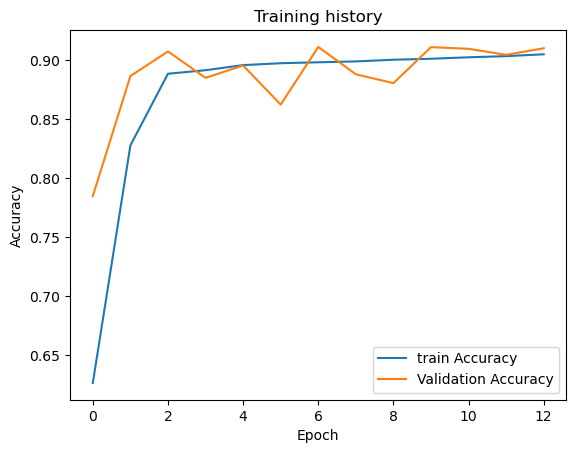

In [37]:
plt.plot(history['train_Accuracy'], label='train Accuracy')
plt.plot(history['val_Accuracy'], label='Validation Accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

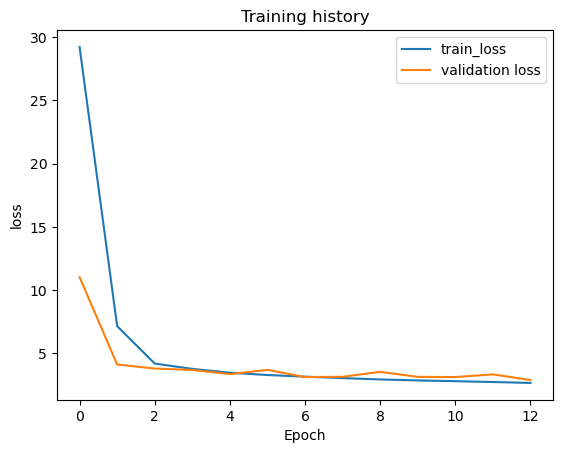

In [38]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()